In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import utils
import scipy.stats as stats
from sklearn.linear_model import LogisticRegressionCV as LR
from sklearn.ensemble import  RandomForestClassifier as RF
from sklearn.metrics import roc_auc_score as AUC
from sklearn.model_selection import train_test_split as TTS
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve as ROC

%matplotlib inline

In [2]:
fires = utils.wrangle()

___
## Background

There are 12 attributes included in the data, and 1 output variable. 

Two of these variables refer to the x and y coordinates of a map specific to Montesinho natural park, the location of the fires. Two variables refer to the time of the fire, one being the day of the week the fire was reported and another is the month of the year. 

Four variables are measurements taken when the fire was first reported and include temperature, relative humidity, rain over the last 30 minutes, and wind speed. 

The remaining four variables, FFMC, DMC, DC, and ISI, are various index metrics which take those four basic meteorologic measurements into account over longer periods of time and in different proportions to determine factors such as moisture levels at different depths of the soil, which suggest how quickly a fire might be likely to spread or the temperatures it might reach.

FFMC, DMC, and DC all take longer term rainfall and temperature averages into account to measure how dry the land is. They consider the past 16 hours, 12 days, and 52 days respectively. FFMC and DMC also consider relative humidity. ISI takes FMC and factors in wind speed to determine how easily surface level fuel will catch fire spread.

The target variable is the area of fire damage, measured in hectares. While each entry is a record of a fire, if the damaged area was less than 0.1 hectare, the value was rounded to 0.
___

There were no null values present in the data frame. I briefly analyzed the data for problematic outliers. It appears that the output variable is strongly skewed to the right. I think this might be helped by applying a log function to the column, so I have added the column 'log' which is equal to the natural log of (area+1). This column is skewed less to the right. It looks like some of the index metrics have some outliers. I don't think I should scrutinize these for accuracy, since the data has already been careful chosen, but I will be sure to consider their role in model fitting.

## What can be learned from the distribution of the target variable?

The output variable is extremely skewed to the right. Normally transformations would be able to hide this problem and present a somewhat normal distribution for analysis. In this case, the high number of 0 values is a problem in that no transformations can space these small fires into a nice distribution. There is a loss of information.

A natural log transformation ouf the output variable will be tested during the training phase as a solution to counteract this. I will transform the area data now, so the rest of the this analysis will be using log(area+1) instead of area. The log transformation reduces skew more than the square root in this case.

Since almost half of the fires have size 0, it creates a natural distinction of the fires into two categories. I will create a boolean column, 'small', in the dataframe, which we can use to highlight the different classes in the following charts.

In [3]:
#Summary statistics

fires['area'].describe()

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64

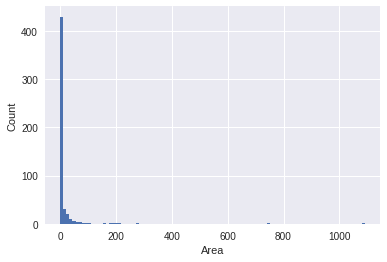

In [4]:
# Histogram

ax = fires['area'].hist(bins=100)
ax.set_xlabel('Area')
ax.set_ylabel('Count')

In [5]:
# Proportion of outputs equal to 0

np.sum(fires.area==0)/len(fires)

0.47775628626692457

In [6]:
# Creating the boolean column and transforming area

fires['area'] = np.log(fires['area']+1)
fires['small'] = fires.area == 0

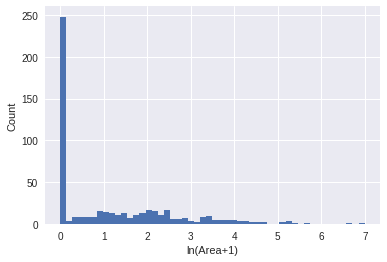

In [7]:
# That's a bit better!

ax = fires['area'].hist(bins=50)
ax.set_xlabel('ln(Area+1)')
ax.set_ylabel('Count')

## Are there any obivous correlations between input variables?

As we can see from the Pearson correlation coefficient matrix, there is not a lot of colinearity going on here. The strongest correlation is between DMC and DC with a coef of 0.68, and we know that these measurements are very similar by nature. This could imply that we have a collection of strong independent indicators for our target variable, but we shouldn't get our hopes up just yet. 

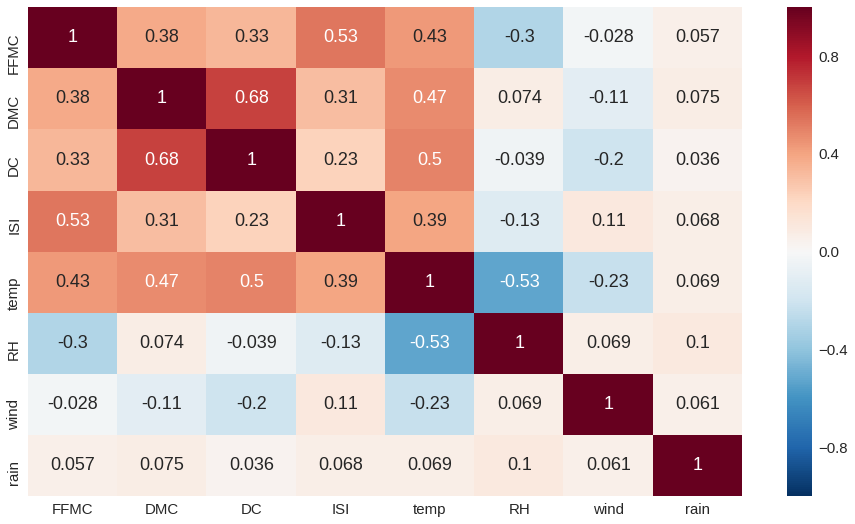

In [8]:
#Pearson correlation coeffecient matrix
sns.set(font_scale=1.5)
plt.subplots(figsize=(16,9))
correlation_mat = fires[fires.columns[4:-2]].corr()
_ = sns.heatmap(correlation_mat, annot=True)

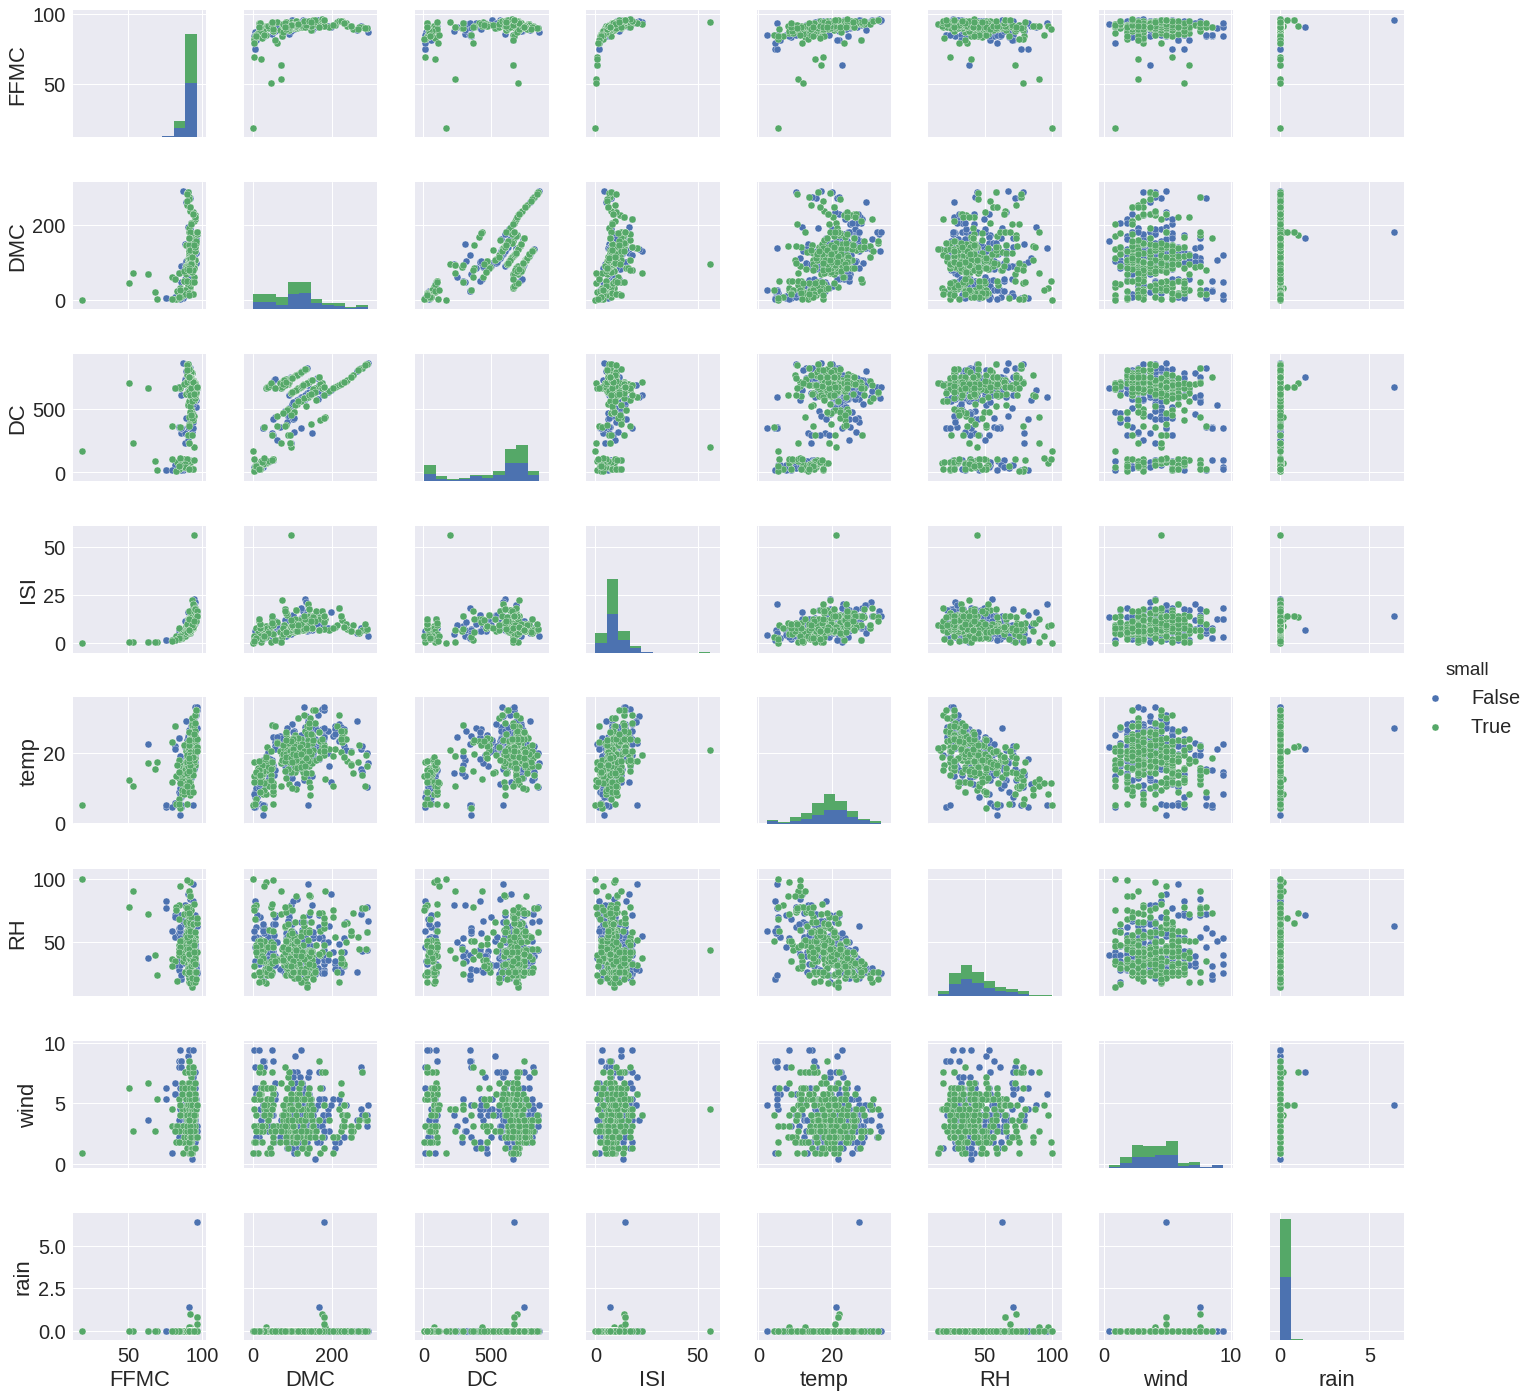

In [28]:
# Seaborn pair plot to further investigate 
sns.set(font_scale=2)
_ = sns.pairplot(data=fires, vars=fires.columns[4:12], hue='small')

___

It seems quite clear that FFMC and ISI have some sort of hyperbolic relationship. This makes sense since FFMC is considered along with wind to calculate ISI.

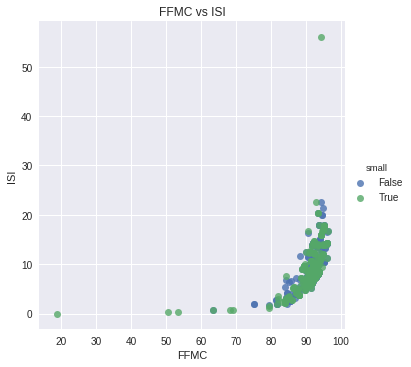

In [10]:
sns.lmplot(data=fires, x='FFMC', y='ISI', fit_reg=False, size=5, hue='small')
plt.title("FFMC vs ISI")
plt.show()

___
DMC and DC are obviously calculated in a very similar way, and the difference is likely some integer value that represents relative humidity and rainfall over the long term. I say this because of the step nature between the implied lines on the chart.

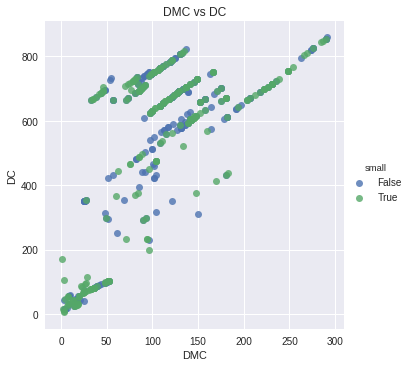

In [11]:
sns.lmplot(data=fires, x='DMC', y='DC', fit_reg=False, hue='small');
plt.title("DMC vs DC")
plt.show()

___
## Are there any obvious relationships between any one input variable and the output?

It looks perhaps like there are some very loose relationships, but each plot is quite nebulous. Looking at the corelation coefficients, we can say that these relationships are even weaker than those between the input variables.

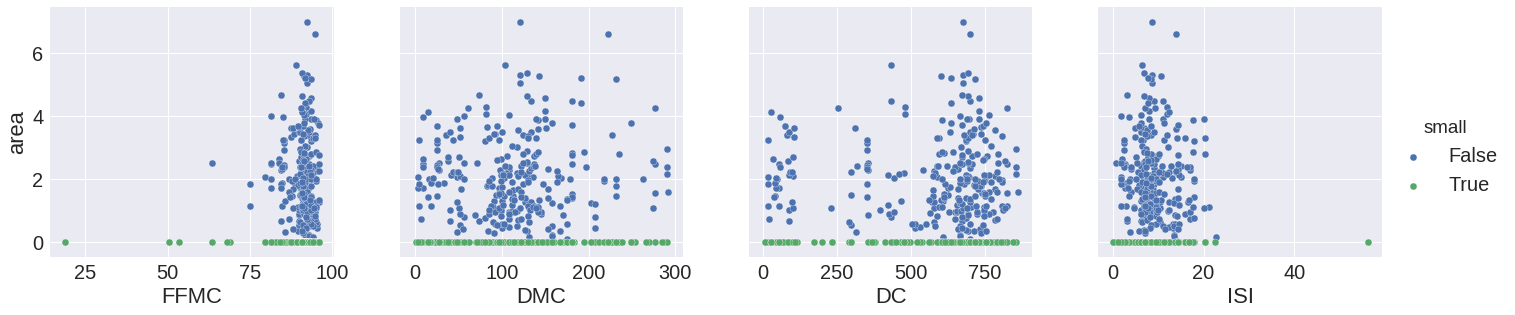

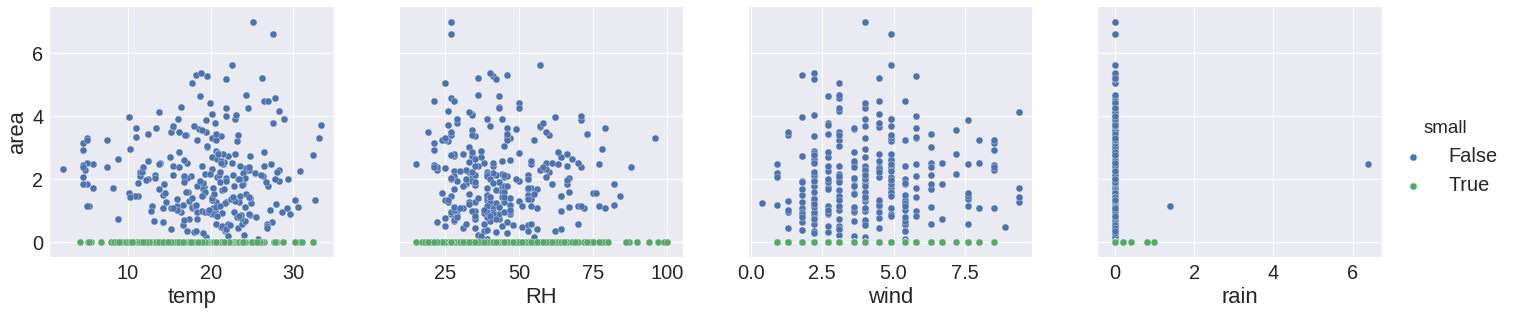

In [29]:
# Pair plots with the output variable
sns.set(font_scale=2)
sns.pairplot(data=fires,y_vars=['area'], x_vars=fires.columns[4:8], size=5, hue='small');
sns.pairplot(data=fires,y_vars=['area'], x_vars=fires.columns[8:12], size=5, hue='small');

In [13]:
# Pearson coeffs with between inputs and area

for col in fires.columns[4:12]:
    print(col, ": ", fires[col].corr(fires['area']))

FFMC :  0.0467985636765
DMC :  0.067152739815
DC :  0.0663597559672
ISI :  -0.0103468786823
temp :  0.0534865489928
RH :  -0.0536621582829
wind :  0.0669734892516
rain :  0.0233113126564


___
## How are fires distributed throughout the year?

There are many more fires in the Summer, but there are also a decent number in the late Winter/early Spring. While there are more larger fires in the Summer, December seems to have the highest average fire size, but this is likely due to the extremely small sample size.

This leads me to wonder if the dryness is distributed in a similar way.

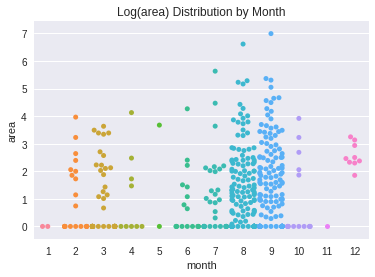

In [14]:
# Area broken down by month

sns.swarmplot(x='month',y='area', data=fires);
plt.title("Log(area) Distribution by Month")
plt.show()

___
The swarmplot showing temperature by month resembles the distribution of acreage burned by month.

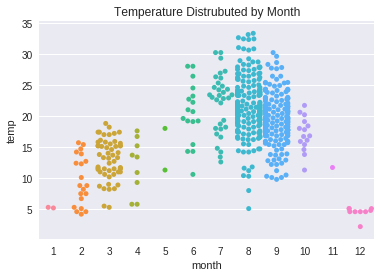

In [15]:
# Area broken down by temperature

sns.swarmplot(x='month',y='temp',data=fires)
plt.title("Temperature Distrubuted by Month")
plt.show()

___
## Are there outliers?

Rain and ISI both seem to have some extreme outliers. I will attempt model training without presence of these fires to see if there is an improvement during testing.

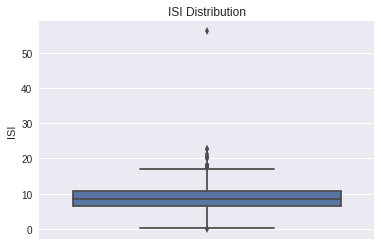

In [16]:
sns.boxplot(y='ISI', data=fires);
plt.title("ISI Distribution")
plt.show()

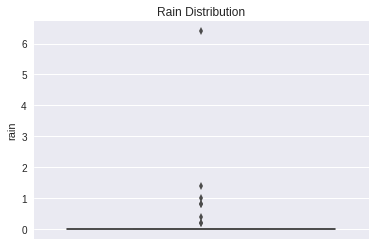

In [17]:
sns.boxplot(y='rain', data=fires);
plt.title("Rain Distribution")
plt.show()

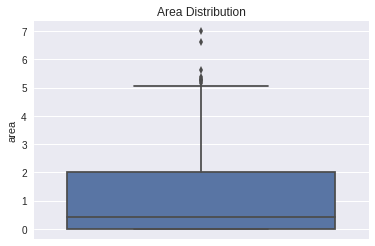

In [18]:
sns.boxplot(y='area',data=fires);
plt.title('Area Distribution')
plt.show()

## How is the distribution of the input variables? Should they be transformed as well?

These two variables, along with FFMC have a pretty sizeable skew rating, and it may be helpful to transform them to reduce this. Square root and natural logarithm functions are typically a good choice. Let's see how they do:

In [19]:
# Skew of each variable

for col in ['FFMC', 'ISI', 'rain', 'area']:
    print(col,": ", stats.skew(fires[col]))

FFMC :  -6.556512420159405
ISI :  2.5289605503329136
rain :  19.75880335536902
area :  1.2143014263185365


In [20]:
# Square root works well on ISI

for col in ['FFMC', 'ISI', 'rain', 'area']:
    print(col,": ", stats.skew(np.sqrt(fires[col])))

FFMC :  -8.736020514727619
ISI :  0.14760719754095478
rain :  12.456581347185654
area :  0.38608153279434976


In [21]:
# Natural log works well on area

for col in ['FFMC', 'ISI', 'rain', 'area']:
    print(col,": ", stats.skew(np.log(fires[col]+1)))

FFMC :  -11.641491913234134
ISI :  -0.934496427287908
rain :  14.131873547887306
area :  0.5058581694826552


In [22]:
# This hybrid transformation works decently on FFMC

for col in ['FFMC', 'ISI', 'rain', 'area']:
    print(col,": ", stats.skew(np.log(-fires[col]+100)))

FFMC :  1.2824124677984807
ISI :  -4.728582652745404
rain :  -19.888304944841362
area :  -1.2460612614324897


The transformations for ISI and FFMC are worth testing out during the machine learning phase. Rain has too extreme of an outlier, so I will test leaving that out model fitting. 

## Is the data with area=0 distinguishable from the rest?

In [23]:
 # Create simple train/test split
def Diff():
    lr_scores = []
    rf_scores = []
    actual = np.array([])
    pred_lr = np.array([])
    pred_rf = np.array([])
    kf = KFold(n_splits=5, shuffle=True)
    for tr, te in kf.split(fires):
   
        Xtr, Xte, Ytr, Yte = fires[fires.columns[8:12]].iloc[tr], fires[fires.columns[8:12]].iloc[te], fires['small'].iloc[tr], fires['small'].iloc[te]
        actual = np.concatenate((actual, te))
        
        # LogisticRegressionCV and create AUC score
        lr = LR()
        lr = lr.fit(Xtr, Ytr)
        Y_lr = lr.predict(Xte)
        pred_lr = np.concatenate((pred_lr,lr.predict_proba(Xte).flatten()))
        lr_scores.append(AUC(Yte, Y_lr))

        # RandomForest and AUC score
        rf = RF(n_estimators=50, n_jobs=-1)
        rf = rf.fit(Xtr, Ytr)
        Y_rf = rf.predict(Xte)
        pred_rf = np.concatenate((pred_rf,rf.predict_proba(Xte).flatten()))
        rf_scores.append(AUC(Yte, Y_rf))    

    return np.mean(lr_scores), np.mean(rf_scores), actual, pred_lr, pred_rf

In [24]:
# Here we see a 50-55% chance of correctly predicting whether our data belongs to a small or large fire.

lr, rf, actual, pred_lr, pred_rf = Diff()
print(lr, rf)

0.485120128041 0.531676607837


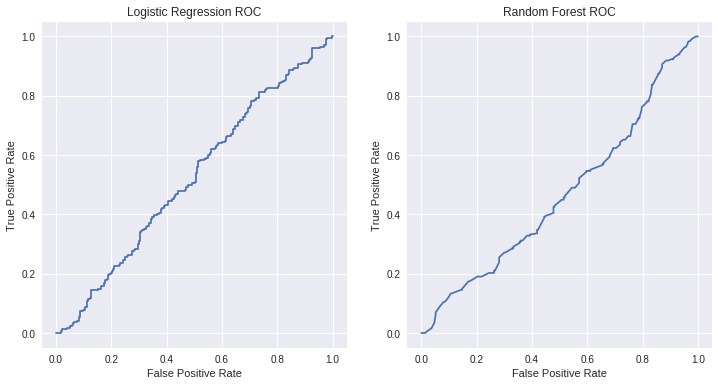

In [25]:
# ROC curves for Logistic Regression and Random Forest ROC

actual = actual.astype(np.int)
actual = fires.small.values[actual]
preds_lr = []
preds_rf = []
for i in range(len(pred_rf)):
    if i%2==0:
        preds_lr.append(pred_lr[i])
        preds_rf.append(pred_rf[i])

fpr1, tpr1, thresholds1 = ROC(actual, preds_lr)
fpr2, tpr2, thresholds2 = ROC(actual, preds_rf)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.plot(fpr1, tpr1)
ax1.set_title('Logistic Regression ROC')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')

ax2.plot(fpr2, tpr2)
ax2.set_title('Random Forest ROC')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')

plt.show()